In [1]:
from ingestion import make_cleaned, make_train_test
from metadata_helpers import save_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.regressor import ResidualsPlot
from sklearn.metrics import mean_squared_error
# XGBoost serially fits weak learners like DecisionTreeRegressor


In [2]:
X_train, X_test, y_train, y_test = make_train_test()

categoric_cols = X_train.select_dtypes(include=object).columns.tolist()
OH_encoder = SklearnTransformerWrapper(transformer=OneHotEncoder(
    sparse_output=False, drop='if_binary', min_frequency=0.1, handle_unknown='ignore'), variables=categoric_cols)
pipe = make_pipeline(OH_encoder, XGBRegressor(
    booster='gbtree', n_jobs=2, random_state=42))
num_trees_range = np.int64(np.linspace(200, 400.0, num=5))
depth_range = [1, 2, 3, 4]
gs = GridSearchCV(n_jobs=8, estimator=pipe, cv=10,
                  scoring='neg_root_mean_squared_error', param_grid={'xgbregressor__max_depth': depth_range,
                                                                     'xgbregressor__n_estimators': num_trees_range})


In [3]:
gs.fit(X_train, y_train)


/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 15, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [6, 11, 14, 31] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/p

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('sklearntransformerwrapper',
                                        SklearnTransformerWrapper(transformer=OneHotEncoder(drop='if_binary',
                                                                                            handle_unknown='ignore',
                                                                                            min_frequency=0.1,
                                                                                            sparse_output=False),
                                                                  variables=['MSSubClass',
                                                                             'MSZoning',
                                                                             'Street',
                                                                             'Alley',
                                                                             'LotShape',
                                                                             'LandContour',
                                                                             'Utilities',
                                                                             'LotConfig',
                                                                             'LandSlope',
                                                                             'Neighborhood',
                                                                             'Condition1',
                                                                             'Co...
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100, n_jobs=2,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=42, ...))]),
             n_jobs=8,
             param_grid={'xgbregressor__max_depth': [1, 2, 3, 4],
                         'xgbregressor__n_estimators': array([200, 250, 300, 350, 400])},
             scoring='neg_root_mean_squared_error')

In [4]:
gs.best_params_


{'xgbregressor__max_depth': 2, 'xgbregressor__n_estimators': 350}

/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 15, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 15, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 15, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 15, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/en

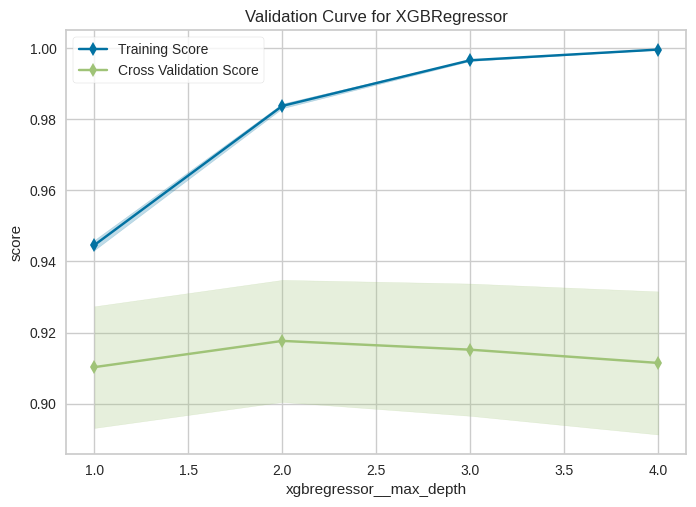

<AxesSubplot: title={'center': 'Validation Curve for XGBRegressor'}, xlabel='xgbregressor__max_depth', ylabel='score'>

In [5]:
pipe_validation = make_pipeline(OH_encoder, XGBRegressor(
    booster='gbtree', n_jobs=8, random_state=42, n_estimators=350))
viz = ValidationCurve(
    pipe_validation, cv=10, param_name='xgbregressor__max_depth', param_range=depth_range
)
viz.fit(X_train, y_train)
viz.show()


/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 11, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 11, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


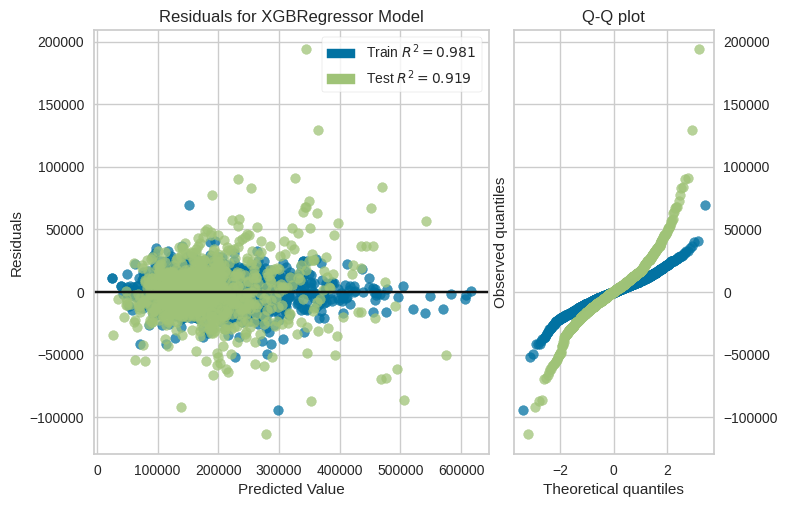

<AxesSubplot: title={'center': 'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [6]:
pipe_final = make_pipeline(OH_encoder, XGBRegressor(
    booster='gbtree', n_jobs=2, random_state=42, n_estimators=350, max_depth=2))
visualizer = ResidualsPlot(pipe_final, hist=False, qqplot=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()


In [7]:
rmse_test = mean_squared_error(
    pipe_final.predict(X_test), y_test, squared=False)
print(f"rmse = {rmse_test}")


rmse = 22550.20511839363


/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 11, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [8]:
save_score(pipe_final, rmse_test)
